In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers # lr 조정할때 쓰임

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import numpy as np
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('2.Kaggle/210722 titanic/train.csv', header=0)
test = pd.read_csv('2.Kaggle/210722 titanic/test.csv', header=0)

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


PassengerId : 승객 ID

Survived:  0은 죽었다는 의미, 1은 생존의 의미

Pclass : 좌석 등급

Name : 승객 이름

Age : 승객 나이

SibSp: 함께 탑승한 형제 자매 또는 배우자의 수

Parch: 함께 탑승한 부모, 아이의 수

Ticket : 티켓 번호

Fare : 티켓 가격

Cabin: 객실 번호

Embarked : 탑승 항구

결측치(누락 데이터) 처리 : train N/A 확인

In [3]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
test.info()
test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

 '([A-Za-z]+)\.' : 정규표현식
 
 대문자 A-Z로 시작하면서 소문자 a-z가 여러개이면서 마침표 .로 끝나는 것을 추출한다는 의미
 
 예로, Braund, Mr. Owen Harris 에서 Mr 를 추출한다는 말

In [5]:
train['Name'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
test['Name'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
train.Name.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [6]:
train.Name.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Countess      1
Capt          1
Sir           1
Mme           1
Don           1
Lady          1
Ms            1
Jonkheer      1
Name: Name, dtype: int64

Name 의 값을 정수로 만들기

In [7]:
train['Name'] = train['Name'].astype('category').cat.codes
test['Name'] = test['Name'].astype('category').cat.codes

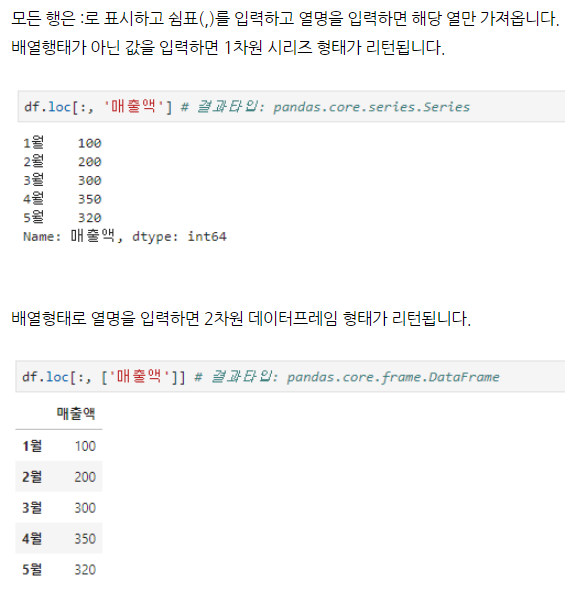

Embarked의 결측치 2개에 대해 가장많은 S값을 결측치에 대입

In [8]:
print(train.Embarked.value_counts())
print(test.Embarked.value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    270
C    102
Q     46
Name: Embarked, dtype: int64


In [9]:
train.loc[train.Embarked.isnull(), 'Embarked'] = train['Embarked'].fillna('S')
test.loc[test.Embarked.isnull(), 'Embarked'] = test['Embarked'].fillna('S')

Fare의 결측치 1개에 대해 Pclass의 그룹별 값의 평균치를 결측치에 대입

In [10]:
test.loc[test.Fare.isnull(), 'Fare']  = train.groupby("Pclass").Fare.transform(np.mean)

Cabin의 첫글자 알파벳하나만 저장

In [11]:
for i in train:
    train['Cabin'] = train['Cabin'].str[:1]

In [12]:
for i in test:
    test['Cabin'] = test['Cabin'].str[:1]

In [13]:
train.Cabin.value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

In [14]:
train['Cabin'] = train['Cabin'].fillna('Z')
test['Cabin'] = test['Cabin'].fillna('Z')

In [15]:
train['Cabin'] = train['Cabin'].astype('category').cat.codes
test['Cabin'] = test['Cabin'].astype('category').cat.codes

In [16]:
train.Cabin.value_counts()

8    687
2     59
1     47
3     33
4     32
0     15
5     13
6      4
7      1
Name: Cabin, dtype: int64

In [17]:
test.Cabin.value_counts()

7    327
2     35
1     18
3     13
4      9
5      8
0      7
6      1
Name: Cabin, dtype: int64

Cabin 과 Pclass의 연관성이 있어서 Canin의 N/A값을 Pclass에서 가져오기로함

In [18]:
train.loc[train.Cabin.isnull(), 'Cabin']  = train.groupby("Pclass").Cabin.transform(np.mean)
test.loc[test.Cabin.isnull(), 'Cabin']  = test.groupby("Pclass").Cabin.transform(np.mean)

Age의 결측치에 대해 Name의 그룹별 나이의 평균값을 결측치에 대입

groupby("Name").Age.transform('median') 에서 groupby로 묶여진 인덱스에 Age의 np.mean(평균값)으로 transform된다.

Text(0.5, 1.0, 'Age Distribution')

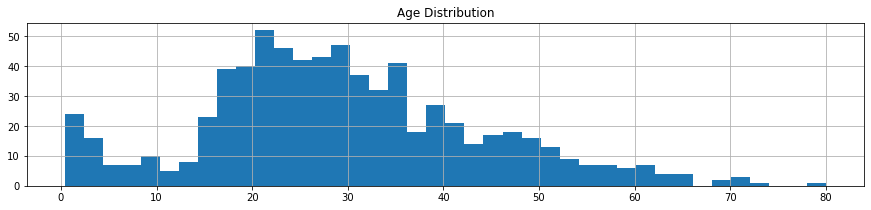

In [19]:
plt.figure(figsize=(15, 3))
train['Age'].hist(bins=40)
plt.title('Age Distribution')

In [20]:
train.loc[train.Age.isnull(), 'Age'] = train.groupby("Name").Age.transform(np.mean)
test.loc[test.Age.isnull(), 'Age'] = test.groupby("Name").Age.transform(np.mean)

In [21]:
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            1
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [22]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Test의 Age에 결측치 하나가 왜 발생하는지 모르지만 평균값 30을 넣어줌

In [23]:
test[test['Age'].isnull()==True] = 30

Sex 와 Embarked 값을 category로 변환

In [24]:
train['Sex'] = train['Sex'].astype('category').cat.codes
train['Embarked'] = train['Embarked'].astype('category').cat.codes
test['Sex'] = test['Sex'].astype('category').cat.codes
test['Embarked'] = test['Embarked'].astype('category').cat.codes

Ticket은 번호에 따른 나이나 fair에 상관관계가 없음을 확인하여 드랍시킴

In [25]:
train = train.drop(['Ticket'], axis = 1)
test = test.drop(['Ticket'], axis = 1)

In [26]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    int8   
 4   Sex          891 non-null    int8   
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    int8   
 10  Embarked     891 non-null    int8   
dtypes: float64(2), int64(5), int8(4)
memory usage: 52.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name       

Modeling

In [28]:
x = train[["PassengerId", "Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]]
y = train[["Survived"]]

x_final = test[["PassengerId", "Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]]

In [62]:
x_final["PassengerId"][50:100]

50    942
51    943
52    944
53    945
54    946
55    947
56    948
57    949
58    950
59    951
60    952
61    953
62    954
63    955
64    956
65    957
66    958
67    959
68    960
69    961
70    962
71    963
72    964
73    965
74    966
75    967
76    968
77    969
78    970
79    971
80    972
81    973
82    974
83    975
84    976
85    977
86    978
87    979
88     30
89    981
90    982
91    983
92    984
93    985
94    986
95    987
96    988
97    989
98    990
99    991
Name: PassengerId, dtype: int64

6/6 [==============================] - 0s 499us/step - loss: 0.5302 - accuracy: 0.8101
evaluate(train)0.8216 / evaluate(test)0.8101


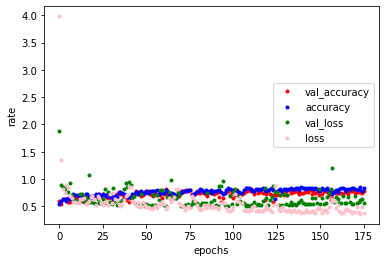

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)

model = Sequential()
model.add(Dense(1000, input_dim=10, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 모델 학습과정 설정
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 자동중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=100)

#모델실행
history = model.fit(x_train, y_train, validation_split=0.33, epochs=3000, batch_size=50, verbose=0,
                    callbacks=[early_stopping_callback])

print("evaluate(train)%.4f / evaluate(test)%.4f" %(model.evaluate(x_train,y_train)[1], model.evaluate(x_test,y_test)[1]))

#테스트셋으로 실험 오차값 저장
y_loss = history.history['loss']
y_vloss = history.history['val_loss']

#학습셋으로 정확도 값 저장
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']

#x값을 지저앟고 정확도를 파란색, 오차를 빨간색
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vacc, "o", c="red", markersize=3, label='val_accuracy')
plt.plot(x_len, y_acc, "o", c="blue", markersize=3, label='accuracy')
plt.plot(x_len, y_vloss, "o", c="green", markersize=3, label='val_loss')
plt.plot(x_len, y_loss, "o", c="pink", markersize=3, label='loss')
plt.legend(loc='right')
plt.xlabel('epochs')
plt.ylabel('rate')


plt.show()

In [56]:
predictions = model.predict(x_final)
pred = []
for i in predictions:
    if i[0] < 0.5: i[0] = 0
    else: i[0] = 1
    pred.append(int(i[0]))
submission = pd.DataFrame(data = zip(x_final["PassengerId"], pred), columns = ['PassengerId', 'Survived'])
submission.to_csv('./submission2.csv', index = False)

In [61]:
x_final["PassengerId"][50:100]

50    942
51    943
52    944
53    945
54    946
55    947
56    948
57    949
58    950
59    951
60    952
61    953
62    954
63    955
64    956
65    957
66    958
67    959
68    960
69    961
70    962
71    963
72    964
73    965
74    966
75    967
76    968
77    969
78    970
79    971
80    972
81    973
82    974
83    975
84    976
85    977
86    978
87    979
88     30
89    981
90    982
91    983
92    984
93    985
94    986
95    987
96    988
97    989
98    990
99    991
Name: PassengerId, dtype: int64